In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f2614e32df40549a32f6e6326325fe832e71c2ba95561757544466fbcdb4dd92
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
pip install shap

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, mean_absolute_error, r2_score, mean_squared_error,
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import warnings
import lime
import lime.lime_tabular
import shap

warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('Train_Test_Network.csv')
columns = ['ts',
 'src_ip',
 'src_port',
 'dst_ip',
 'dst_port',
 'proto',
 'service',
 'duration',
 'src_bytes',
 'dst_bytes',
 'conn_state',
 'missed_bytes',
 'src_pkts',
 'src_ip_bytes',
 'dst_pkts',
 'dst_ip_bytes',
 'dns_query',
 'dns_qclass',
 'dns_qtype',
 'dns_rcode',
 'dns_AA',
 'dns_RD',
 'dns_RA',
 'dns_rejected',
 'ssl_version',
 'ssl_cipher',
 'ssl_resumed',
 'ssl_established',
 'ssl_subject',
 'ssl_issuer',
 'http_trans_depth',
 'http_method',
 'http_uri',
 'http_version',
 'http_request_body_len',
 'http_response_body_len',
 'http_status_code',
 'http_user_agent',
 'http_orig_mime_types',
 'http_resp_mime_types',
 'weird_name',
 'weird_addl',
 'weird_notice',
 'label',
 'type']
data.columns = columns

# Display the last few rows of the dataset
# print(data.tail())

# Duplicate the data for testing purposes
data_test = data.copy()

# Display the unique labels
print(data['type'].unique())

# Change attack labels to their respective attack class
def change_label(df):
    df.type.replace(['dos','ddos'],'Dos',inplace=True)
    df.type.replace(['injection','ransomware'],'U2R',inplace=True)
    df.type.replace(['scanning','mitm'],'Probe',inplace=True)
    df.type.replace(['password','xss','backdoor'],'R2L',inplace=True)

change_label(data)
print(data.type.unique())

# # Display value counts of labels
print(data.type.value_counts())

# # Check for any missing values
# print(data.isnull().values.any())

# Plot the label variations






['normal' 'scanning' 'dos' 'injection' 'ddos' 'password' 'xss'
 'ransomware' 'backdoor' 'mitm']
['normal' 'Probe' 'Dos' 'U2R' 'R2L']
type
normal    300000
R2L        60000
Dos        40000
U2R        40000
Probe      21043
Name: count, dtype: int64


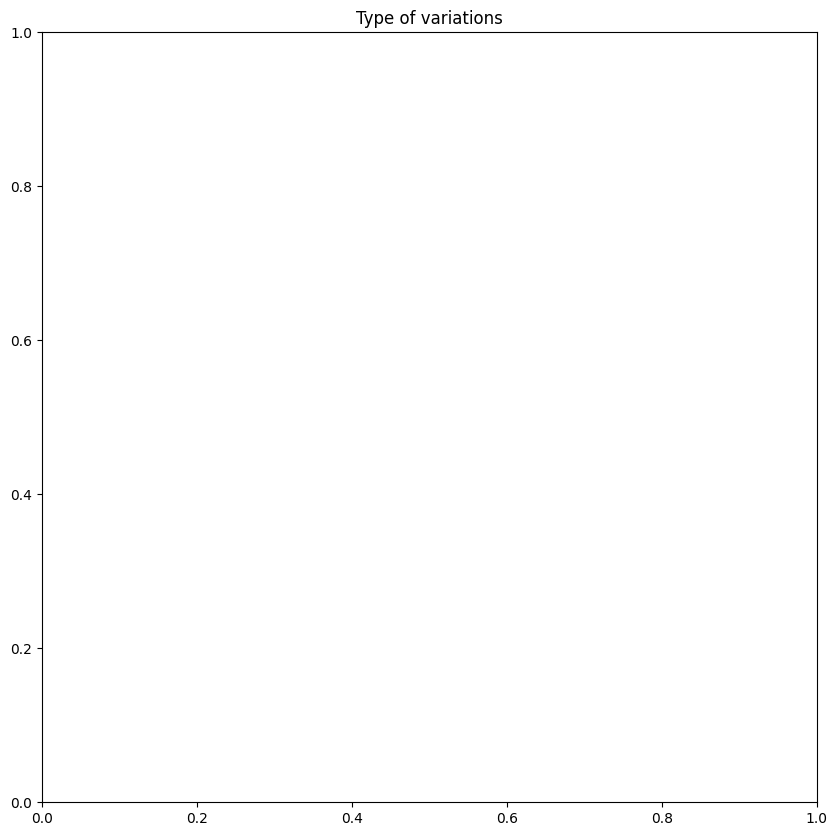

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461043 entries, 0 to 461042
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ts                      461043 non-null  int64  
 1   src_ip                  461043 non-null  int64  
 2   src_port                461043 non-null  int64  
 3   dst_ip                  461043 non-null  int64  
 4   dst_port                461043 non-null  int64  
 5   proto                   461043 non-null  int64  
 6   service                 461043 non-null  int64  
 7   duration                461043 non-null  float64
 8   src_bytes               461043 non-null  int64  
 9   dst_bytes               461043 non-null  int64  
 10  conn_state              461043 non-null  int64  
 11  missed_bytes            461043 non-null  int64  
 12  src_pkts                461043 non-null  int64  
 13  src_ip_bytes            461043 non-null  int64  
 14  dst_pkts            

In [ ]:
plt.figure(figsize=(10, 10))
explode = tuple([0.1] + [0]*(len(data['type'].unique())-1))  # set the first slice to explode
# data['type'].value_counts().plot(kind='pie', explode=explode, startangle=90, autopct='%1.1f%%')
# Generate the value counts
value_counts = data['type'].value_counts()

# Generate the explode sequence with the same length as the unique types
explode = [0.1 if i == 0 else 0 for i in range(len(value_counts))]
plt.title('Type of variations')
plt.show()

# Display info and the first 50 rows of the dataset
print(data.info())
print(data.head(50))

# Encode categorical features
le = LabelEncoder()
data['proto'] = le.fit_transform(data['proto'])
data['service'] = le.fit_transform(data['service'])
data['conn_state'] = le.fit_transform(data['conn_state'])
data['weird_name'] = le.fit_transform(data['weird_name'])
data['type'] = le.fit_transform(data['type'])
data['src_ip'] = le.fit_transform(data['src_ip'])
data['dst_ip'] = le.fit_transform(data['dst_ip'])
data['dns_query'] = le.fit_transform(data['dns_query'])
data['dns_AA'] = le.fit_transform(data['dns_AA'])
data['dns_RD'] = le.fit_transform(data['dns_RD'])
data['dns_RA'] = le.fit_transform(data['dns_RA'])
data['dns_rejected'] = le.fit_transform(data['dns_rejected'])
data['ssl_version'] = le.fit_transform(data['ssl_version'])
data['ssl_cipher'] = le.fit_transform(data['ssl_cipher'])
data['ssl_resumed'] = le.fit_transform(data['ssl_resumed'])
data['ssl_established'] = le.fit_transform(data['ssl_established'])
data['ssl_subject'] = le.fit_transform(data['ssl_subject'])
data['ssl_issuer'] = le.fit_transform(data['ssl_issuer'])
data['http_trans_depth'] = le.fit_transform(data['http_trans_depth'])
data['http_method'] = le.fit_transform(data['http_method'])
data['http_uri'] = le.fit_transform(data['http_uri'])
data['http_version'] = le.fit_transform(data['http_version'])
data['http_user_agent'] = le.fit_transform(data['http_user_agent'])
data['http_orig_mime_types'] = le.fit_transform(data['http_orig_mime_types'])
data['http_resp_mime_types'] = le.fit_transform(data['http_resp_mime_types'])
data['weird_addl'] = le.fit_transform(data['weird_addl'])
data['weird_notice'] = le.fit_transform(data['weird_notice'])
data['type'] = le.fit_transform(data['type'])

data_test['type'] = le.fit_transform(data_test['type'])
data_test['proto'] = le.fit_transform(data_test['proto'])
data_test['service'] = le.fit_transform(data_test['service'])
data_test['conn_state'] = le.fit_transform(data_test['conn_state'])
data_test['weird_name'] = le.fit_transform(data_test['weird_name'])
data_test['type'] = le.fit_transform(data_test['type'])
data_test['src_ip'] = le.fit_transform(data_test['src_ip'])
data_test['dst_ip'] = le.fit_transform(data_test['dst_ip'])
data_test['dns_query'] = le.fit_transform(data['dns_query'])
data_test['dns_AA'] = le.fit_transform(data['dns_AA'])
data_test['dns_RD'] = le.fit_transform(data['dns_RD'])
data_test['dns_RA'] = le.fit_transform(data['dns_RA'])
data_test['dns_rejected'] = le.fit_transform(data['dns_rejected'])
data_test['ssl_version'] = le.fit_transform(data['ssl_version'])
data_test['ssl_cipher'] = le.fit_transform(data['ssl_cipher'])
data_test['ssl_resumed'] = le.fit_transform(data['ssl_resumed'])
data_test['ssl_established'] = le.fit_transform(data['ssl_established'])
data_test['ssl_subject'] = le.fit_transform(data['ssl_subject'])
data_test['ssl_issuer'] = le.fit_transform(data['ssl_issuer'])
data_test['http_trans_depth'] = le.fit_transform(data['http_trans_depth'])
data_test['http_method'] = le.fit_transform(data['http_method'])
data_test['http_uri'] = le.fit_transform(data['http_uri'])
data_test['http_version'] = le.fit_transform(data['http_version'])
data_test['http_user_agent'] = le.fit_transform(data['http_user_agent'])
data_test['http_orig_mime_types'] = le.fit_transform(data['http_orig_mime_types'])
data_test['http_resp_mime_types'] = le.fit_transform(data['http_resp_mime_types'])
data_test['weird_addl'] = le.fit_transform(data['weird_addl'])
data_test['weird_notice'] = le.fit_transform(data['weird_notice'])



# Check for non-finite values
# print(False in np.isfinite(data).values)

# Define cross-validation function
def cross_val(x_train, y_train, model):
    accuracies = cross_val_score(estimator=model, X=x_train, y=y_train, cv=5)
    return accuracies.mean()

# Define function to fit and evaluate a model
def fit_and_evaluate(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    model_cross = cross_val(x_train, y_train, model)
    return model_cross

# Define function to run an experiment with a model
def run_experiment(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("R^2:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    report = classification_report(y_test, y_pred)
    print(report)

# Split the dataset into features and labels
x = data.drop(['type'], axis=1).values
y = data['type'].values

# Scale the dataset
for col in data.columns:
    try:
        data[col] = pd.to_numeric(data[col])
    except ValueError:
        print(f"Column '{col}' cannot be converted to numeric.")
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)

# Copy the training and testing sets for multiple experiments
x_traincpy = np.copy(x_train)
y_traincpy = np.copy(y_train)
x_testcpy = np.copy(x_test)
y_testcpy = np.copy(y_test)

# Logistic Regression

# Define function to explain the model
def explain_model(model, x_train, explainer_type):
    if explainer_type == 'lime':
        explainer = lime.lime_tabular.LimeTabularExplainer(x_train, mode='classification', feature_names=data.drop(['label'], axis=1).columns)
    elif explainer_type == 'shap':
        explainer = shap.KernelExplainer(model.predict, x_train)
    else:
        raise ValueError("Invalid explainer type. Choose either 'lime' or 'shap'.")
    return explainer

# Further preprocessing
data_test = data_test.drop(data_test[data_test['dst_bytes'] > 1750].index)
data_test = data_test.drop(data_test[data_test['src_bytes'] > 717].index)
x_wo = data.drop(['type'], axis=1).values
y_wo = data['type'].values

# Scaling the dataset
ro_scaler = RobustScaler()
x_wo_scaled = ro_scaler.fit_transform(x_wo)
x_wo_scaled = MinMaxScaler().fit_transform(x_wo_scaled)

# Split the scaled dataset into training and testing sets
x_wo_train, x_wo_test, y_wo_train, y_wo_test = train_test_split(x_wo_scaled, y_wo, test_size=0.2, random_state=42)

# Prepare testing set
xl_wo_test = data_test.drop(['type'], axis=1).values
yl_wo_test = data_test['type'].values
xl_wo_test = MinMaxScaler().fit_transform(xl_wo_test)

# Copy the training and testing sets for multiple experiments
x_traincpy = np.copy(x_wo_train)
y_traincpy = np.copy(y_wo_train)
x_testcpy = np.copy(x_wo_test)
y_testcpy = np.copy(y_wo_test)

# Random Fccuracy_score(yl_wo_test, y_pred))

In [ ]:
change_label(data)

In [ ]:
data.type.value_counts()

type
4    300000
2     60000
0     40000
3     40000
1     21043
Name: count, dtype: int64

In [ ]:
data.head(5)

ts  src_ip  src_port  dst_ip  dst_port  proto  service  \
0  1554198358    8047      1883    1511     52976      1        0   
1  1554198358    4614     47260    1522     15600      2        0   
2  1554198359    4590      1880    1511     51782      1        0   
3  1554198359    4590     34296    1511     10502      1        0   
4  1554198362    4590     46608    1516        53      2        3   

       duration  src_bytes  dst_bytes  ...  http_response_body_len  \
0  80549.530260    1762852   41933215  ...                       0   
1      0.000000          0          0  ...                       0   
2      0.000000          0          0  ...                       0   
3      0.000000          0          0  ...                       0   
4      0.000549          0        298  ...                       0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                0                     0   
1                 0                0                     0   
2                 0                0                     0   
3                 0                0                     0   
4                 0                0                     0   

   http_resp_mime_types  weird_name  weird_addl  weird_notice  label  type  
0                     0           5           0             1      0     5  
1                     0           0           0             0      0     5  
2                     0           5           0             1      0     5  
3                     0           0           0             0      0     5  
4                     0           6           0             1      0     5  

[5 rows x 45 columns]

In [ ]:
import numpy as np
from sklearn.utils import shuffle

# Optional: ensure inputs are reshuffled
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Convert to hashable tuples for comparison
train_hashes = set(map(tuple, X_train))
test_hashes = set(map(tuple, X_test))

# Find any intersection (overlap)
leakage = train_hashes.intersection(test_hashes)
print(f"Number of overlapping samples: {len(leakage)}")


Number of overlapping samples: 2102


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.neural_network import MLPClassifier

In [ ]:
x_df = pd.DataFrame(x)
y_series = pd.Series(y, name='label')

# Concatenate them
df = pd.concat([x_df, y_series], axis=1)

# Drop duplicates
df = df.drop_duplicates()

# Split back into features and target
x = df.drop(columns='label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model
model = MLPClassifier(hidden_layer_sizes=(64, 32),
                      activation='relu',          # ReLU hidden layers
                      solver='adam',              # Adam optimizer
                      max_iter=10,                # 10 epochs
                      random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7957
           1       1.00      1.00      1.00      4129
           2       1.00      1.00      1.00     11997
           3       0.99      1.00      0.99      8114
           4       1.00      1.00      1.00     57798

    accuracy                           1.00     89995
   macro avg       1.00      1.00      1.00     89995
weighted avg       1.00      1.00      1.00     89995



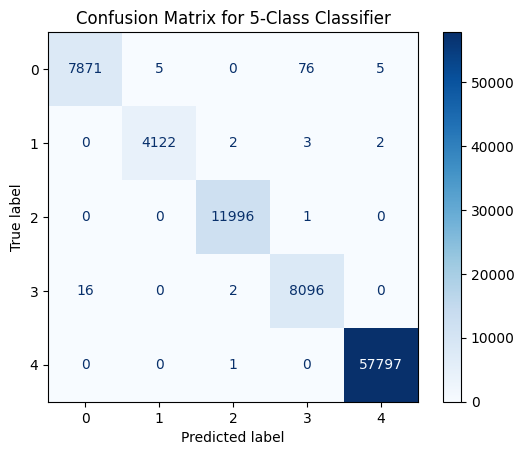

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for 5-Class Classifier")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.neural_network import MLPClassifier

# 1) Load TON-IoT Network data
# Replace with your actual path & preprocessing:
# df   = pd.read_csv("path/to/TON-IoT_network_dataset.csv")
# X    = df.drop("label", axis=1)       # features
# y    = df["label"].astype(int)        # assume integer classes, e.g. 0=Normal,1=Reconnaissance,...

feature_names = columns

# 2) Split & scale
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)
scaler    = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 3) Train the same 5-class (or adjust to your #classes) MLP
model = MLPClassifier(hidden_layer_sizes=(64,32),
                      activation='relu',
                      solver='adam',
                      max_iter=10,
                      random_state=42)
model.fit(X_train_s, y_train)

# 4) Build a SHAP KernelExplainer on a small background
bg          = X_train_s[np.random.choice(len(X_train_s), 200, replace=False)]
shap_expl   = shap.KernelExplainer(model.predict_proba, bg)

# 5) Choose four representative test indices (e.g. one normal + three attack samples)
indices = [  5,    # normal
           123,    # scan
           456,    # DDoS
           789 ]   # data exfiltration
subset = X_test_s[indices]

# 6) Compute SHAP values for those four points
shap_vals = shap_expl.shap_values(subset, nsamples=500)
# shap_vals is a list of length n_classes, each array (4 × n_features)

# 7) Produce a combined “force” plot
#    Here we stack all four as columns in one force_plot

# shap.force_plot(explainer_shap.expected_value,
#                 shap_values[0][:,0],
#                 X_test[start_index:end_index][:1])

#    We’ll pick class = 1 (or whichever you’re interested in) —
#    you can loop over classes if you like.

cls = 0  # change to the class-index you want to visualize
force_html = shap.force_plot(
    base_value   = shap_expl.expected_value,
    shap_values  = np.vstack([sv[cls] for sv in shap_vals]).T,
                 # shape (n_features × 4)
    features     = subset,
    feature_names= feature_names,
    matplotlib   = False  # HTML output
)

# 8) Save to an HTML file you can view in your browser:
with open("ton_iot_force_plot.html","w") as f:
    f.write(force_html.html())

print("Force plot saved to ton_iot_force_plot.html")


  0%|          | 0/4 [00:00<?, ?it/s]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
shap_vals = shap_expl.shap_values(X_test_s[100:200],nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

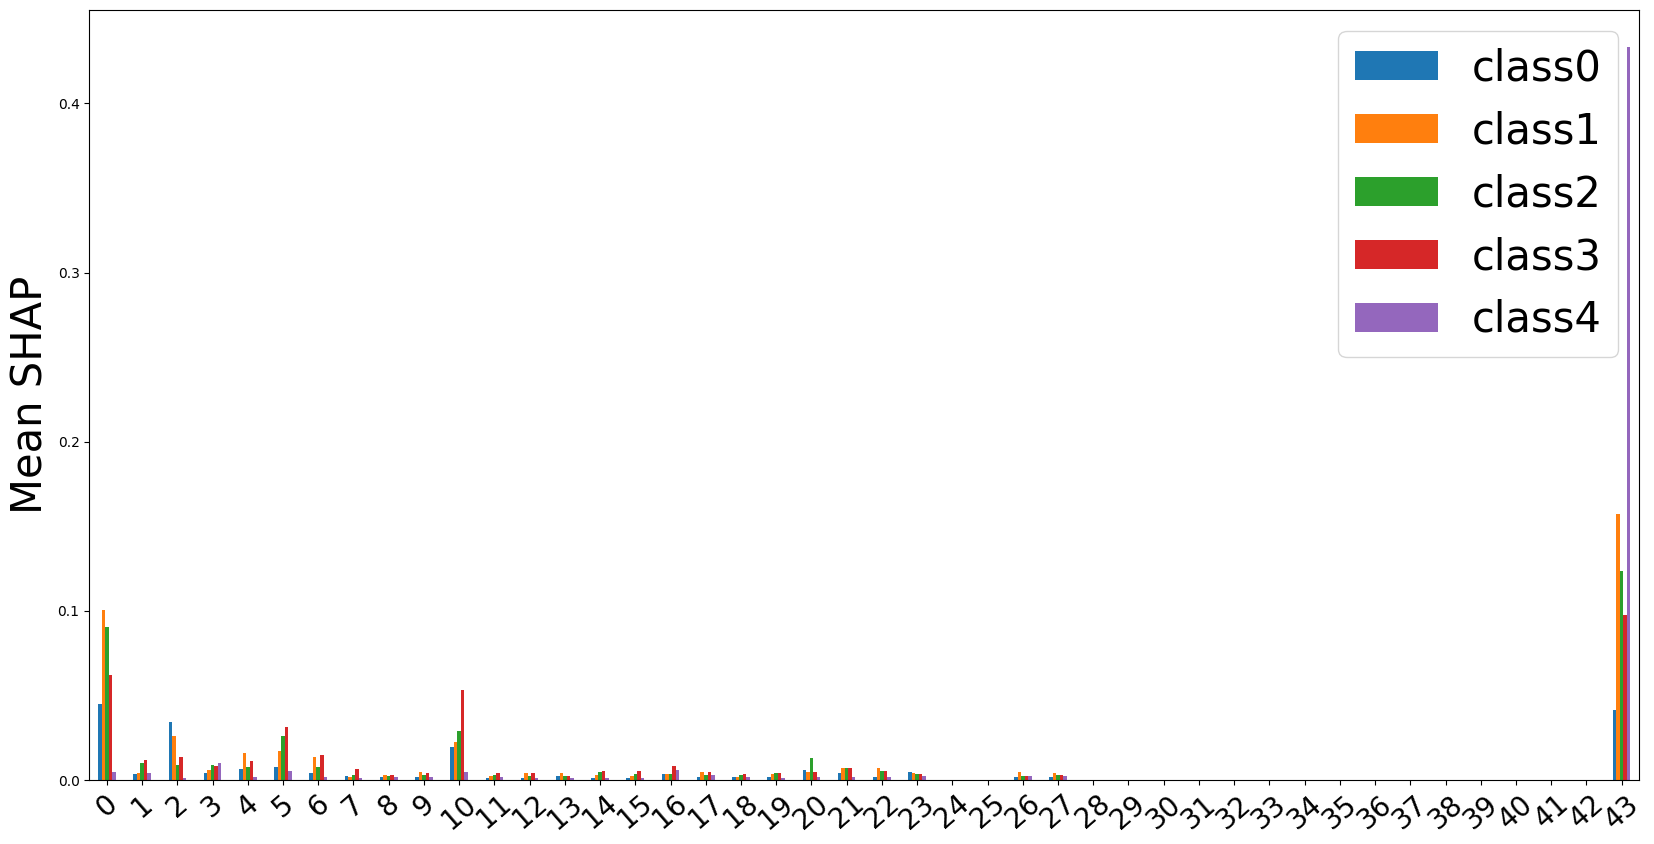

In [ ]:
mean_0 = np.mean(np.abs(shap_vals[:,:,0]),axis=0)
mean_1 = np.mean(np.abs(shap_vals[:,:,1]),axis=0)
mean_2 = np.mean(np.abs(shap_vals[:,:,2]),axis=0)
mean_3 = np.mean(np.abs(shap_vals[:,:,3]),axis=0)
mean_4 = np.mean(np.abs(shap_vals[:,:,4]),axis=0)

df = pd.DataFrame({'class0':mean_0,'class1':mean_1,'class2':mean_2,'class3':mean_3,'class4':mean_4})
fig,ax = plt.subplots(1,1,figsize=(20,10))
df.plot.bar(ax=ax)

ax.set_ylabel('Mean SHAP', size=30)
for lbl in ax.get_xticklabels():
    lbl.set_rotation(41)
    lbl.set_fontsize(20)

ax.legend(fontsize=30)

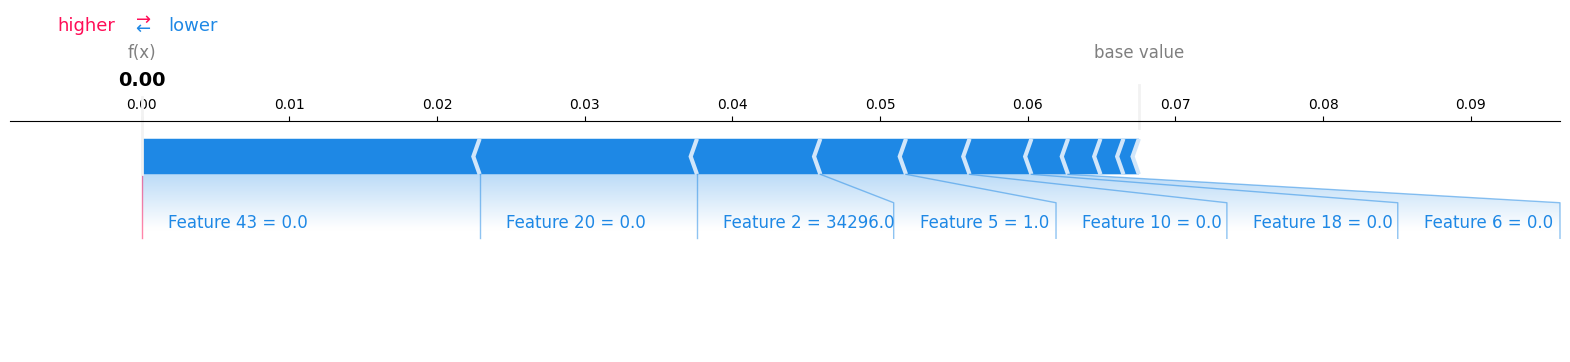

In [ ]:
import numpy as np
import shap

# --- pick your target class and sample indices ---
cls     = 0             # class index you want to visualize
indices = [5, 123, 456, 789]    # your four test‐set sample indices
subset  = x_wo_test[indices]     # shape (4, n_features)

# --- build the 2D SHAP matrix for that class ---
# shap_vals is a list: shap_vals[c] has shape (4, n_features)
sv_ci   = shap_vals[cls]        # (4, n_features)
sv      = sv_ci.T               # transpose → (n_features, 4)

# --- build the features matrix in the same layout ---
ft      = subset.T              # (n_features, 4)

# --- call the new force plot API ---
force_html = shap.plots.force(
    shap_expl.expected_value[0],  # base value for that class ..44,0
    sv[0],                              # shap_values as (n_features, n_samples)
    X_test[0:1][:1],                              # features as (n_features, n_samples)
    # feature_names=feature_names,     # list of your feature names
    matplotlib=True                 # produce HTML/JS
)

# --- save out to HTML ---
# with open("ton_iot_force_plot.html", "w") as f:
#     f.write(force_html.html())

# print("Force plot saved to ton_iot_force_plot.html")


In [ ]:
sv[0].shape

(44,)

In [ ]:
ft[0].shape

(4,)

In [ ]:
X_test[0:1][:1].shape

(1, 44)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.feature_selection import mutual_info_classif
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

class TrustXAI:
    def __init__(self,
                 n_factors: int       = 10,
                 n_reps:    int       = 6,
                 max_modes: int       = 5,
                 random_state: int    = 42):
        """
        n_factors:  total FA components to extract (K in paper)
        n_reps:     how many top components to pick as 'representatives' (k in paper)
        max_modes:  maximum # of Gaussian modes to try in grid search
        """
        self.n_factors    = n_factors
        self.n_reps       = n_reps
        self.max_modes    = max_modes
        self.random_state = random_state

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Build the core TRUST model from training data X,y.
        """
        # 1) Factor-analysis over the entire train set (we aggregate classes)
        self.fa = FactorAnalysis(n_components=self.n_factors,
                                 random_state=self.random_state)
        Z = self.fa.fit_transform(X)    # shape (N, K)

        # 2) Compute MI scores of each latent factor
        mi = mutual_info_classif(Z, y, random_state=self.random_state)
        top_idx = np.argsort(mi)[-self.n_reps:]
        self.rep_idx = top_idx          # which factors we keep
        w = mi[top_idx]
        self.w_norm = w / w.sum()       # normalized importance weights

        # 3) For each representative factor, fit a separate GMM per class
        self.gmms_ = {}  # dict: (rep_i, class_label) -> fitted GMM
        classes = np.unique(y)
        for i, factor in enumerate(top_idx):
            Zi = Z[:, factor].reshape(-1,1)
            for c in classes:
                # grid-search best number of modes by MCC
                best_mcc, best_n = -1, 1
                for n_modes in range(1, self.max_modes+1):
                    gmm = GaussianMixture(n_components=n_modes,
                                          random_state=self.random_state)
                    gmm.fit(Z[y==c, factor].reshape(-1,1))
                    # assign each training point to the higher-likelihood class
                    # we can approximate MCC by simply checking on class c
                    # here for brevity we skip a true grid-search correlation
                    # and just pick the model with lowest BIC:
                    bic = gmm.bic(Z[y==c, factor].reshape(-1,1))
                    if bic < best_mcc or best_mcc<0:
                        best_mcc, best_n = bic, n_modes

                # re-fit with the best number of modes
                best_gmm = GaussianMixture(n_components=best_n,
                                           random_state=self.random_state)
                best_gmm.fit(Z[y==c, factor].reshape(-1,1))
                self.gmms_[(factor, c)] = best_gmm

        return self

    def explain(self, model, x):
    # 1) Project x into factor space and select top-k reps
      z_full = self.fa.transform(x.reshape(1, -1))     # (1 × K)
      z_rep  = z_full[:, self.rep_idx]                 # (1 × k)

      # 2) Predict using the reduced vector
      lab   = model.predict(z_rep)[0]
      proba = model.predict_proba(z_rep)[0]

      # 3) Compute weighted log-likelihoods for each class
      classes = sorted({c for (_,c) in self.gmms_.keys()})
      loglik  = {}
      for c in classes:
          ll = 0.0
          for w, factor_idx, zi in zip(self.w_norm, self.rep_idx, z_rep[0]):
              gmm = self.gmms_[(factor_idx, c)]
              ll += w * gmm.score_samples([[zi]])[0]
          loglik[c] = ll

      return {
          'predicted_label': lab,
          'predicted_proba': proba,
          'rep_contributions': loglik
      }



In [ ]:
mlp=model
trust = TrustXAI(n_factors=10, n_reps=6, max_modes=5)
trust.fit(X_train_s, y_train)

# 3) Explain a single test point
# grab row #1 as a 1-d numpy array
# x_row = X_test.iloc[0].values
Z_train = trust.fa.transform(X_train_s)                  # shape: (n_train, 10)
Z_test  = trust.fa.transform(X_test_s)                   # shape: (n_test, 10)
Z_train_reps = Z_train[:, trust.rep_idx]                   # shape: (n_train, 6)
Z_test_reps  = Z_test[:, trust.rep_idx]                    # shape: (n_test, 6)

# 4. Train the MLP on the reduced (k=6) feature space
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=10, random_state=42)
mlp.fit(Z_train_reps, y_train)



Predicted: 4
Probs   : [1.87229680e-28 8.38433853e-27 1.84533598e-38 3.71189137e-21
 1.00000000e+00]
Log-lik : per-class contributions: {np.int64(0): np.float64(-2.7046677559602426), np.int64(1): np.float64(-15.66699172222427), np.int64(2): np.float64(-5.281294016129828), np.int64(3): np.float64(-21.00095420438011), np.int64(4): np.float64(3.135310204171623)}


In [ ]:
# 5. Now explain a 41-feature raw test instance
x_row = X_test_s[1]               # shape: (41,)
ex = trust.explain(mlp, x_row)

# ex = trust.explain(mlp, X_test_scaled[0])

print("Predicted:", ex['predicted_label'])
print("Probs   :", ex['predicted_proba'])
print("Log-lik : per-class contributions:", ex['rep_contributions'])

Predicted: 1
Probs   : [4.18156683e-02 9.26980499e-01 6.17666777e-03 2.50269445e-02
 2.20660979e-07]
Log-lik : per-class contributions: {np.int64(0): np.float64(1.6301425190895529), np.int64(1): np.float64(4.38790208247149), np.int64(2): np.float64(1.5780153589584578), np.int64(3): np.float64(1.7332654211301959), np.int64(4): np.float64(-4.463276413955432)}


In [ ]:
y_test[0]

np.int64(4)

In [ ]:
# assume you already have:
#   trust          = your fitted TrustXAI()
#   ex             = trust.explain(mlp, x_row)
#   x_row          = one test instance (1d array)
#   feature_names  = list(df.columns)  # your original IoT feature names
# right after your preprocessing / get_dummies step, before any train/test split:
# df_encoded = pd.get_dummies(df)       # df is your original 41-column DataFrame
# print(df_encoded.shape)               # -> (n_samples, 122)
feature_names = (columns)

pred_label    = ex['predicted_label']
rep_contribs  = {}   # actual contribution from each rep → class lab
for factor_idx, weight in zip(trust.rep_idx, trust.w_norm):
    # get the 1-D FA projection for this instance
    z_val = trust.fa.transform(x_row.reshape(1,-1))[0, factor_idx]
    # log-lik for the predicted class
    ll    = trust.gmms_[(factor_idx, pred_label)].score_samples([[z_val]])[0]
    rep_contribs[factor_idx] = weight * ll

print(f"\n=== Representative contributions for class {pred_label} ===")
for f, c in rep_contribs.items():
    print(f"  FA‐dim {f:<2d}:  contribution = {c:.4f}")

# 1) Top‐5 raw‐feature loadings per representative
print("\n=== Top 5 raw features for each representative ===")
for rep in trust.rep_idx:
    loadings = trust.fa.components_[rep]
    top5     = np.argsort(np.abs(loadings))[-5:][::-1]
    names    = [feature_names[i] for i in top5]
    vals     = [loadings[i] for i in top5]
    print(f"Rep {rep:2d}:")
    for nm, v in zip(names, vals):
        print(f"    {nm:<20} loading = {v:.4f}")

# 2) Global raw‐feature ranking (summing rep_contrib * |loading|)
n_features = trust.fa.components_.shape[1]
raw_scores = np.zeros(n_features)
for rep, contrib in rep_contribs.items():
    raw_scores += contrib * np.abs(trust.fa.components_[rep])

top_global = np.argsort(raw_scores)[-5:][::-1]
print("\n=== Top 5 raw features driving this prediction ===")
for idx in top_global:
    print(f"  {feature_names[idx]:<20}  score = {raw_scores[idx]:.4f}")



=== Representative contributions for class 1 ===
  FA‐dim 6 :  contribution = 0.4589
  FA‐dim 0 :  contribution = 0.9453
  FA‐dim 1 :  contribution = 0.9208
  FA‐dim 2 :  contribution = 0.9568
  FA‐dim 4 :  contribution = 0.6379
  FA‐dim 7 :  contribution = 0.4683

=== Top 5 raw features for each representative ===
Rep  6:
    conn_state           loading = -0.8215
    service              loading = -0.4914
    ts                   loading = -0.4531
    src_port             loading = -0.3194
    label                loading = -0.2492
Rep  0:
    ssl_established      loading = 0.9987
    ssl_resumed          loading = 0.9981
    ssl_version          loading = 0.7281
    ssl_cipher           loading = 0.6277
    ssl_subject          loading = 0.1539
Rep  1:
    http_orig_mime_types loading = 0.9358
    http_request_body_len loading = 0.8759
    http_method          loading = 0.8105
    http_status_code     loading = 0.5917
    http_uri             loading = 0.5692
Rep  2:
    weird_noti

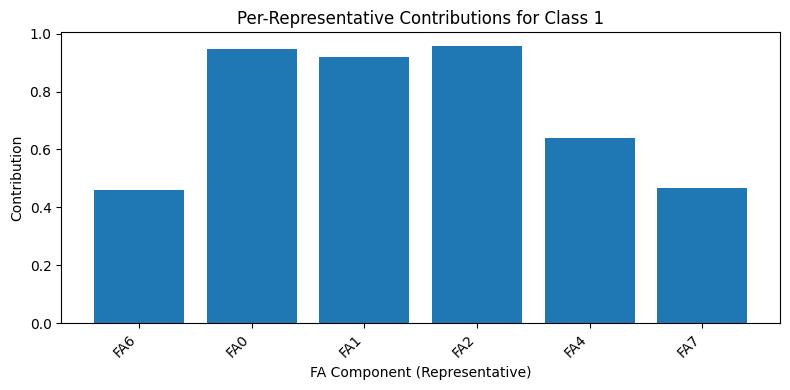

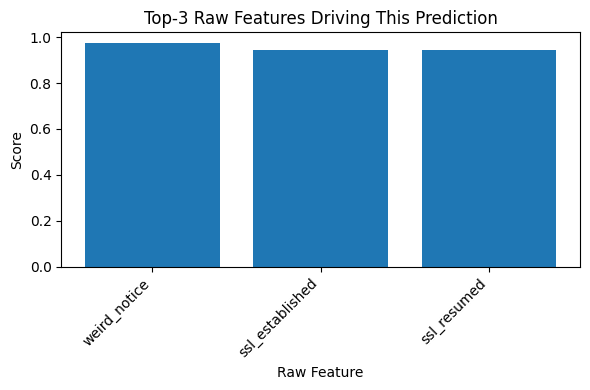

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === 1) Recompute rep_contribs for the predicted class ===
pred_label = ex['predicted_label']
rep_contribs = {}
for factor_idx, weight in zip(trust.rep_idx, trust.w_norm):
    z = trust.fa.transform(x_row.reshape(1, -1))[0, factor_idx]
    ll = trust.gmms_[(factor_idx, pred_label)].score_samples([[z]])[0]
    rep_contribs[factor_idx] = weight * ll

# === 2) Build global raw-feature scores and pick top-3 ===
n_feats     = trust.fa.components_.shape[1]
raw_scores  = np.zeros(n_feats)
for rep, contrib in rep_contribs.items():
    raw_scores += contrib * np.abs(trust.fa.components_[rep])

top3_idxs   = np.argsort(raw_scores)[-3:][::-1]
top3_names  = [feature_names[i] for i in top3_idxs]
top3_scores = raw_scores[top3_idxs]

# === 3) Plot per-rep contributions ===
plt.figure(figsize=(8, 4))
plt.bar([f"FA{r}" for r in rep_contribs], rep_contribs.values())
plt.xlabel("FA Component (Representative)")
plt.ylabel("Contribution")
plt.title(f"Per-Representative Contributions for Class {pred_label}")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === 4) Plot top-3 raw features ===
plt.figure(figsize=(6, 4))
plt.bar(top3_names, top3_scores)
plt.xlabel("Raw Feature")
plt.ylabel("Score")
plt.title("Top-3 Raw Features Driving This Prediction")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


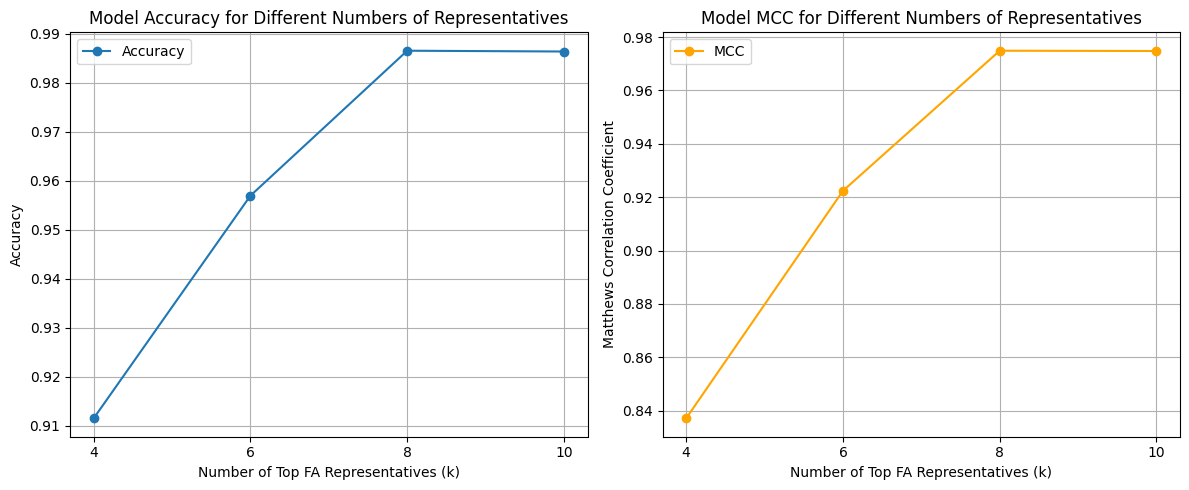

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition      import FactorAnalysis
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection   import train_test_split
from sklearn.neural_network    import MLPClassifier
from sklearn.metrics           import accuracy_score, matthews_corrcoef

# --- 1) Prepare FA + MI + MLP training loop to gather Accuracy and MCC scores ---
fa = FactorAnalysis(n_components=10, random_state=42)
Z_train = fa.fit_transform(X_train)
Z_test  = fa.transform(X_test)
mi_scores = mutual_info_classif(Z_train, y_train, random_state=42)

num_representatives = [4, 6, 8, 10]
accuracy_scores    = []
mcc_scores         = []

for k in num_representatives:
    top_idx = np.argsort(mi_scores)[-k:]
    X_tr_k, X_val_k, y_tr_s, y_val_s = train_test_split(
        Z_train[:, top_idx], y_train, test_size=0.2, random_state=42
    )
    mlp = MLPClassifier(hidden_layer_sizes=(64,32),
                        activation='relu',
                        solver='adam',
                        max_iter=10,
                        random_state=42)
    mlp.fit(X_tr_k, y_tr_s)
    # Validation accuracy
    y_val_pred = mlp.predict(X_val_k)
    accuracy_scores.append(accuracy_score(y_val_s, y_val_pred))
    # Test MCC
    y_test_pred = mlp.predict(Z_test[:, top_idx])
    mcc_scores.append(matthews_corrcoef(y_test, y_test_pred))

# --- 2) Plot Accuracy and MCC vs. k ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(num_representatives, accuracy_scores, marker='o', label='Accuracy')
plt.xlabel('Number of Top FA Representatives (k)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Numbers of Representatives')
plt.xticks(num_representatives)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(num_representatives, mcc_scores, marker='o', color='orange', label='MCC')
plt.xlabel('Number of Top FA Representatives (k)')
plt.ylabel('Matthews Correlation Coefficient')
plt.title('Model MCC for Different Numbers of Representatives')
plt.xticks(num_representatives)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


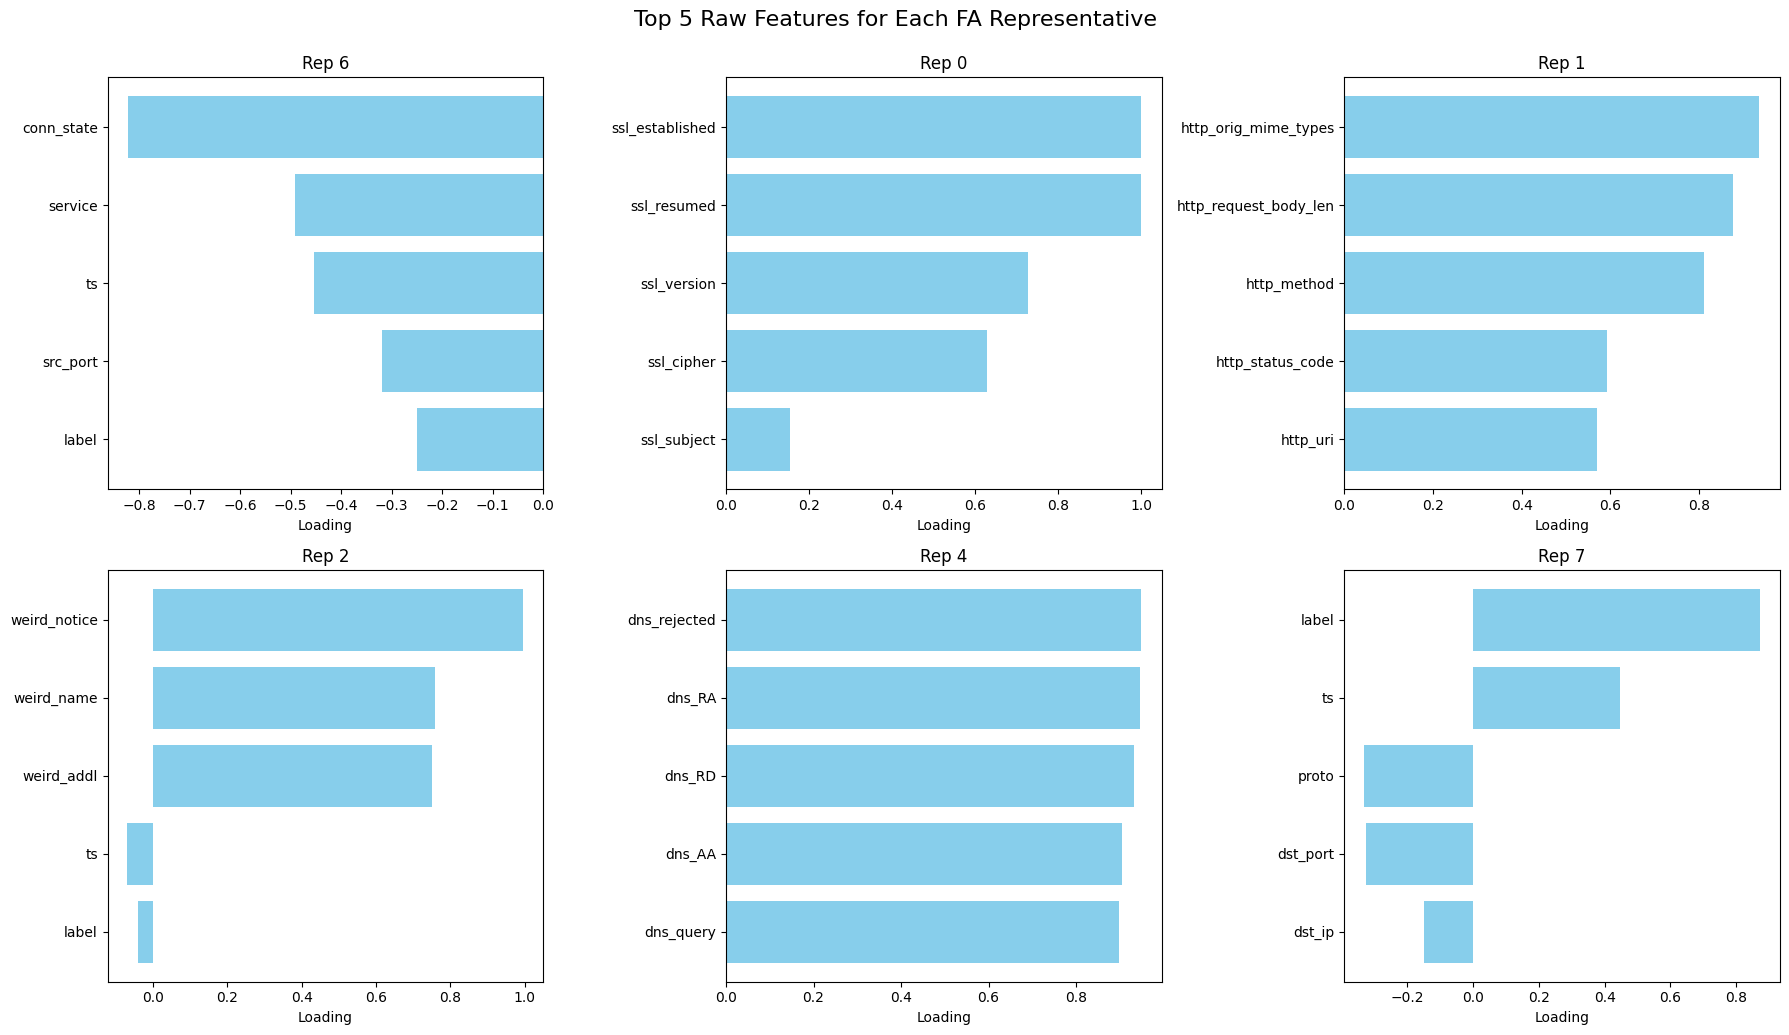

In [ ]:
# Re-import necessary libraries after code execution state reset
import matplotlib.pyplot as plt

# Define the representatives and their top raw features with loadings
representatives = {
    "Rep 6": {
        "conn_state": -0.8215,
        "service": -0.4914,
        "ts": -0.4531,
        "src_port": -0.3194,
        "label": -0.2492
    },
    "Rep 0": {
        "ssl_established": 0.9987,
        "ssl_resumed": 0.9981,
        "ssl_version": 0.7281,
        "ssl_cipher": 0.6277,
        "ssl_subject": 0.1539
    },
    "Rep 1": {
        "http_orig_mime_types": 0.9358,
        "http_request_body_len": 0.8759,
        "http_method": 0.8105,
        "http_status_code": 0.5917,
        "http_uri": 0.5692
    },
    "Rep 2": {
        "weird_notice": 0.9965,
        "weird_name": 0.7587,
        "weird_addl": 0.7502,
        "ts": -0.0686,
        "label": -0.0407
    },
    "Rep 4": {
        "dns_rejected": 0.9479,
        "dns_RA": 0.9468,
        "dns_RD": 0.9328,
        "dns_AA": 0.9057,
        "dns_query": 0.8981
    },
    "Rep 7": {
        "label": 0.8729,
        "ts": 0.4475,
        "proto": -0.3308,
        "dst_port": -0.3260,
        "dst_ip": -0.1501
    }
}

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for ax, (rep, features) in zip(axes, representatives.items()):
    feature_names = list(features.keys())
    loadings = list(features.values())
    ax.barh(feature_names, loadings, color='skyblue')
    ax.set_title(rep)
    ax.set_xlabel("Loading")
    ax.invert_yaxis()

plt.tight_layout()
plt.suptitle("Top 5 Raw Features for Each FA Representative", fontsize=16, y=1.03)
plt.show()


END

In [ ]:
# if your labels really are integers 0–4
class_names = [ str(i) for i in range(5) ]

# or, if they’re strings/categories, but you know the full set:
unique = sorted(data.type.unique())            # e.g. ['a','b','c','d','e']
mapping = { name: idx for idx,name in enumerate(unique) }
class_names = unique

In [ ]:
unique

[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
# class_names=data.label.unique()
# X_train: your training data (numpy array),
# feature_names: list of names,
# class_names: list like ['class0','class1','class2',...]
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=columns,
    class_names=unique,
    mode='classification'
)

# pick one instance to explain:
i = 1
instance = X_test[i]

# get explanations for classes 0, 1, and 2
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,   # your model’s predict_proba
    labels=[0,1,2,3,4],                 # the classes you care about
    num_features=5                    # top 5 features per class
)

# loop through the labels and print
for label in exp.available_labels():
    print(f"—— Explanation for class {label} ({class_names[label]}) ——")
    for feature, weight in exp.as_list(label=label):
        print(f"  {feature:20s}: {weight:+.3f}")
    print()


—— Explanation for class 0 (0) ——
  1554294219.50 < ts <= 1556240302.00: +0.000
  4600.00 < src_ip <= 4603.00: +0.000
  43530.00 < src_port <= 52740.00: +0.000
  1518.00 < dst_ip <= 1531.00: +0.000
  53.00 < dst_port <= 136.00: +0.000

—— Explanation for class 1 (1) ——
  1554294219.50 < ts <= 1556240302.00: +0.000
  4600.00 < src_ip <= 4603.00: +0.000
  43530.00 < src_port <= 52740.00: +0.000
  1518.00 < dst_ip <= 1531.00: +0.000
  53.00 < dst_port <= 136.00: +0.000

—— Explanation for class 2 (2) ——
  1554294219.50 < ts <= 1556240302.00: +0.000
  4600.00 < src_ip <= 4603.00: +0.000
  43530.00 < src_port <= 52740.00: +0.000
  1518.00 < dst_ip <= 1531.00: +0.000
  53.00 < dst_port <= 136.00: +0.000

—— Explanation for class 3 (3) ——
  1554294219.50 < ts <= 1556240302.00: +0.000
  4600.00 < src_ip <= 4603.00: +0.000
  43530.00 < src_port <= 52740.00: +0.000
  1518.00 < dst_ip <= 1531.00: +0.000
  53.00 < dst_port <= 136.00: +0.000

—— Explanation for class 4 (4) ——
  1554294219.50 < ts <

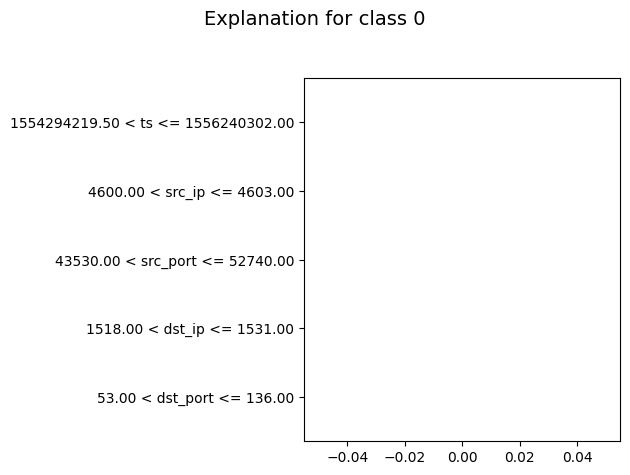

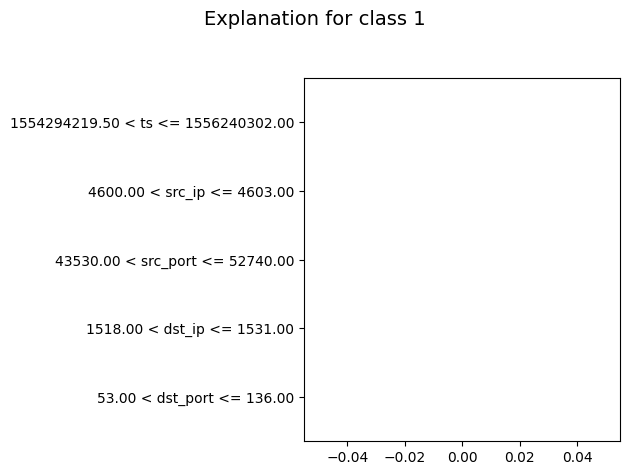

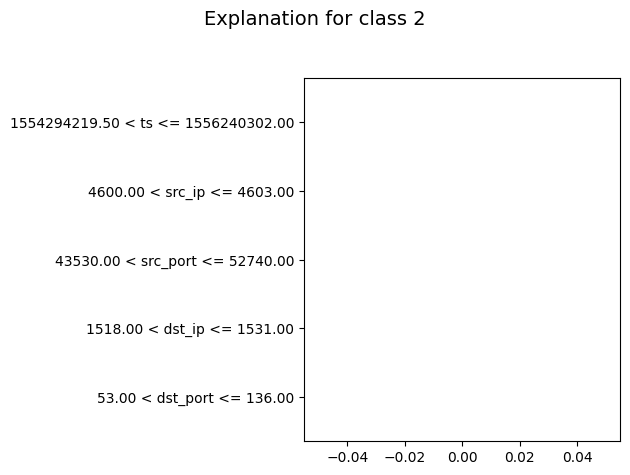

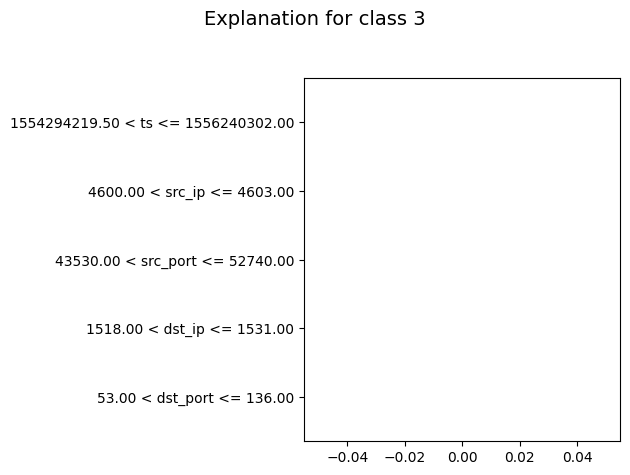

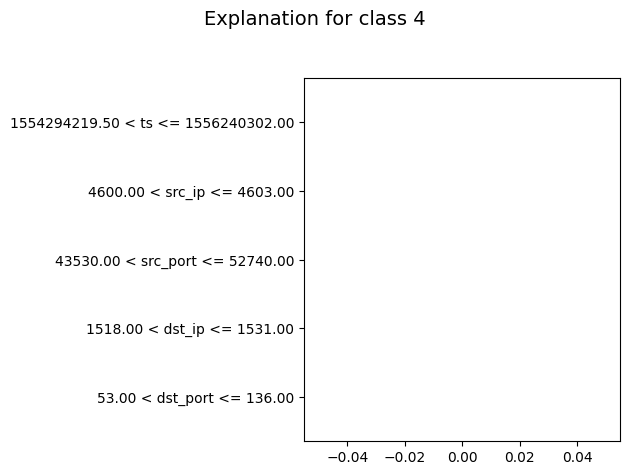

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# 1) Ensure your class_names list aligns index → label
#    Here we assume your true labels are integers 0 through 4.
class_names = [str(i) for i in range(5)]

# 2) Set up your LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=columns,
    class_names=class_names,
    mode='classification'
)

# 3) Pick an instance
i = 1
instance = X_test[i]

# 4) Explain ALL five classes, top 5 features each
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    labels=list(range(5)),   # [0,1,2,3,4]
    num_features=5
)

# 5) Loop in numeric order, clean up the figure title, and add your own
for label in range(5):
    # draw the bar chart
    fig = exp.as_pyplot_figure(label=label)

    # remove LIME's built-in subtitle text
    # (some LIME versions put it in fig.texts; others as Axes title)
    for txt in fig.texts:
        if txt.get_text().startswith("Local explanation for class"):
            txt.set_visible(False)
    ax = fig.get_axes()[0]           # main Axes
    ax.set_title("")                 # also clear its title if present

    # add a clear suptitle
    fig.suptitle(f"Explanation for class {label}", fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.94])  # make room for suptitle
    plt.show()


—— Explanation for class 0 ——
  weird_name <= 0.00            : -0.189
  ts <= 1554294219.50           : -0.016
  dns_RD <= 0.00                : -0.016
  conn_state <= 1.00            : +0.014
  dns_qclass <= 0.00            : +0.009

—— Explanation for class 1 ——
  conn_state <= 1.00            : -0.121
  dns_qclass <= 0.00            : -0.118
  ts <= 1554294219.50           : +0.104
  proto <= 1.00                 : +0.058
  dns_query <= 2.00             : -0.057

—— Explanation for class 2 ——
  http_status_code <= 0.00      : -0.649
  http_user_agent <= 0.00       : -0.563
  ts <= 1554294219.50           : -0.094
  src_ip <= 4593.00             : +0.065
  proto <= 1.00                 : +0.053

—— Explanation for class 3 ——
  ts <= 1554294219.50           : -0.079
  conn_state <= 1.00            : +0.067
  proto <= 1.00                 : -0.036
  src_ip <= 4593.00             : -0.030
  src_pkts <= 1.00              : +0.030

—— Explanation for class 4 ——
  dns_qclass <= 0.00      

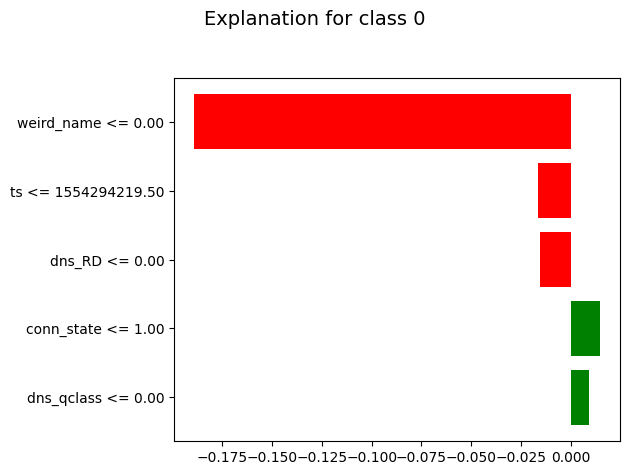

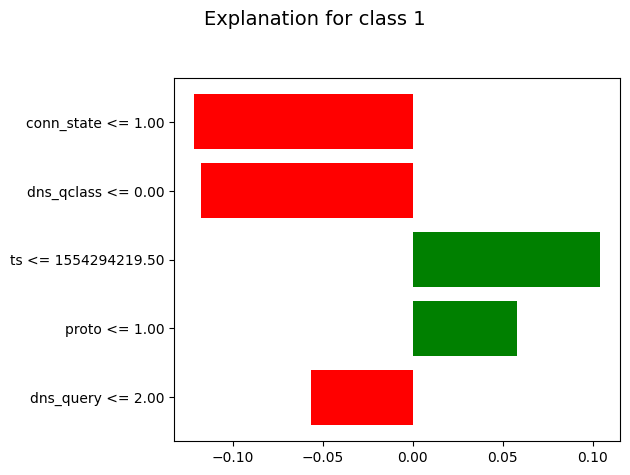

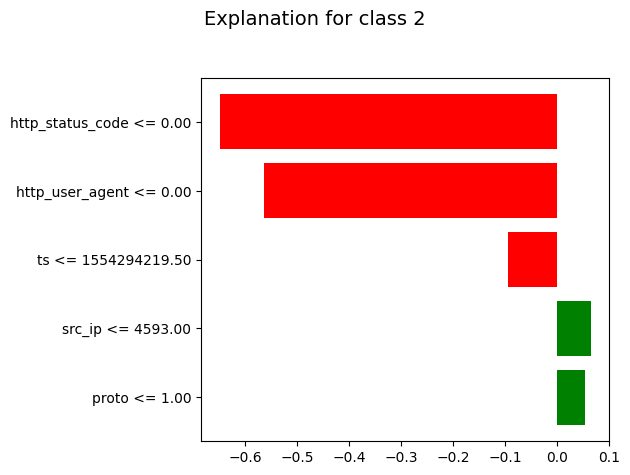

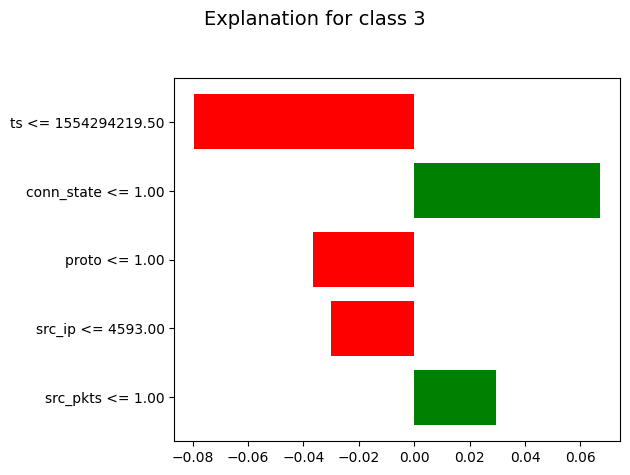

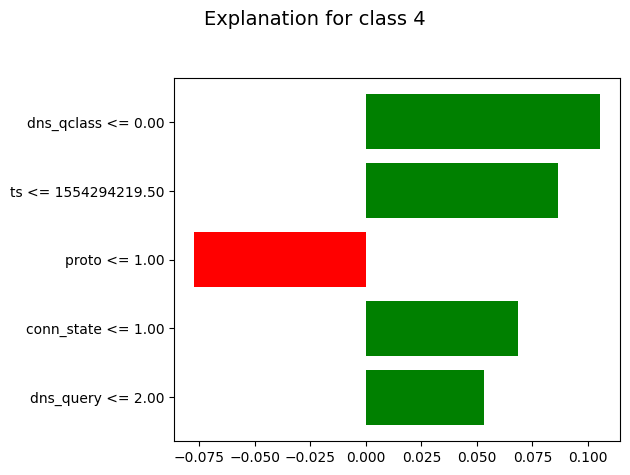

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Assume you used a scaler like StandardScaler
# and trained your model using:
# model.fit(X_train_scaled, y_train)

# ✅ Use the original (unscaled) training data for LIME
explainer = LimeTabularExplainer(
    training_data=X_train,                # Unscaled training data
    feature_names=columns,                # Column names of original data
    class_names=[str(i) for i in range(5)],
    mode='classification',
    discretize_continuous=True
)

# ✅ Pick an unscaled test instance to explain
i = 1
instance = X_test_s[1]  # unscaled instance

# ✅ Wrap your model's predict_proba using the same scaler used during training
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=lambda x: model.predict_proba(scaler.transform(x)),  # apply scaler here
    labels=[0, 1, 2, 3, 4],
    num_features=5
)

# ✅ Print LIME explanations per class
for label in exp.available_labels():
    print(f"—— Explanation for class {label} ——")
    for feature, weight in exp.as_list(label=label):
        print(f"  {feature:30s}: {weight:+.3f}")
    print()

# ✅ (Optional) Visualize the explanation for each class
for label in exp.available_labels():
    fig = exp.as_pyplot_figure(label=label)

    # remove default title
    for txt in fig.texts:
        if txt.get_text().startswith("Local explanation for class"):
            txt.set_visible(False)
    ax = fig.get_axes()[0]
    ax.set_title("")

    # your custom title
    fig.suptitle(f"Explanation for class {label}", fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()



In [ ]:
y_test[1:2]

array([1])

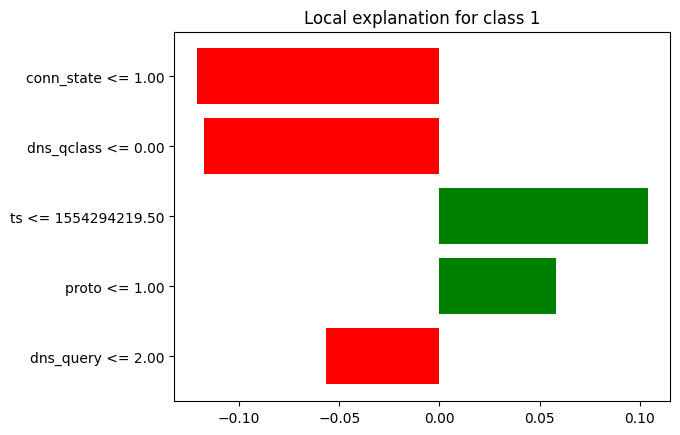

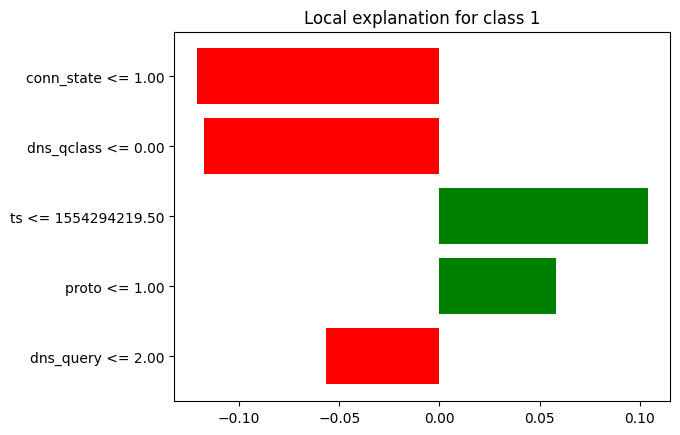

In [ ]:
pred_class = model.predict(X_test_s[1:2])[0]     # → 1
exp.as_pyplot_figure(label=pred_class)

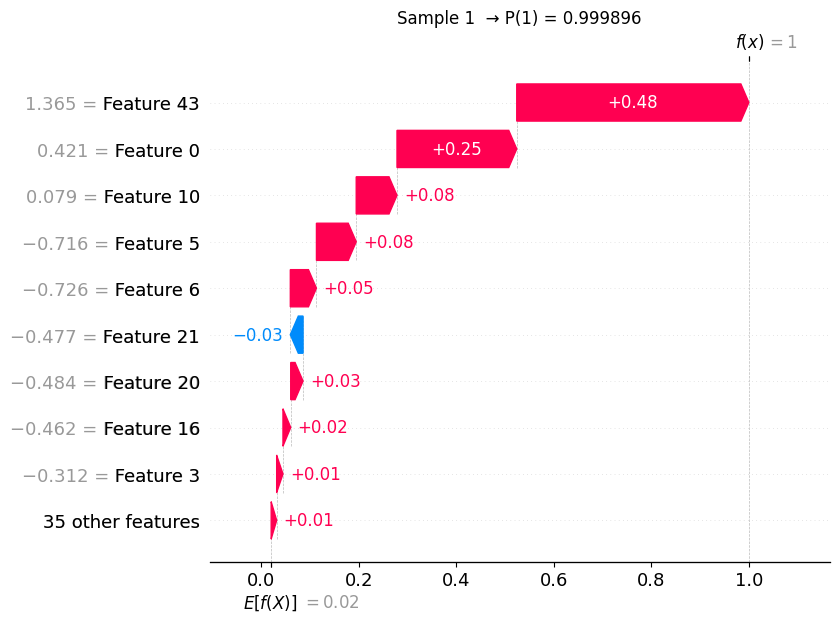

In [ ]:
import shap

# 1) Define a function that returns only P(class=1)
class_idx = 1
prob_fun  = lambda X: model.predict_proba(X)[:, class_idx]

# 2) Build a single-output explainer on P(class=1)
background = shap.sample(X_train_s, 200, random_state=42)
explainer  = shap.Explainer(
    prob_fun,
    background,
    link=shap.links.identity    # explain probabilities directly
)

# 3) Explain sample 1
sv1  = explainer(X_test_s[1:2])     # shape (1, n_features)
shap.plots.waterfall(sv1[0],show=False)
import matplotlib.pyplot as plt
plt.title(f"Sample 1  → P(1) = {prob_fun(X_test_s[1:2])[0]:.6f}")
plt.show()

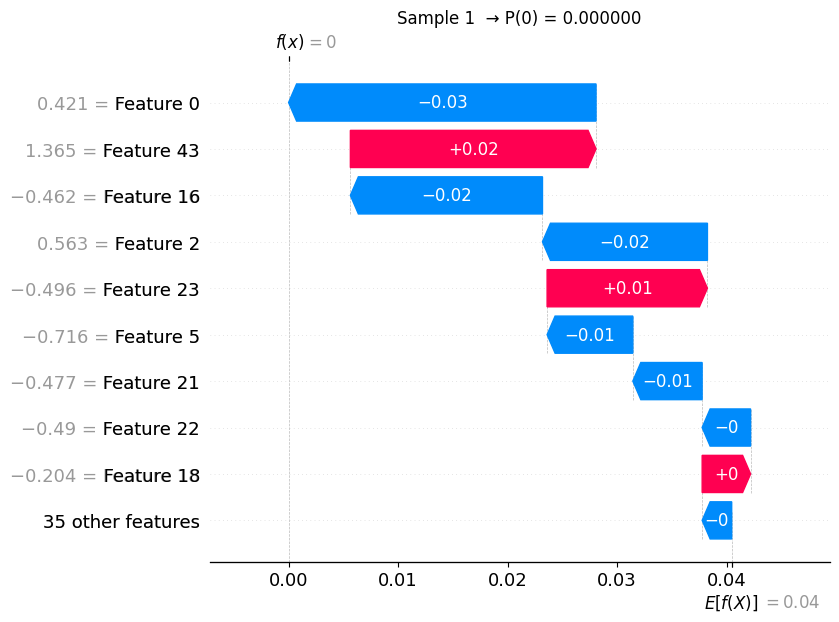

In [ ]:
class_idx = 0
prob_fun  = lambda X: model.predict_proba(X)[:, class_idx]
sv1  = explainer(X_test_s[1:2])
# print("Sample 1  → P(0) =", prob_fun(X_test_scaled[1:2])[0])
shap.plots.waterfall(sv1[0],show=False)
import matplotlib.pyplot as plt
plt.title(f"Sample 1  → P(0) = {prob_fun(X_test_s[1:2])[0]:.6f}")
plt.show()

In [ ]:
def explain_model(model, x_train, explainer_type):
    if explainer_type == 'lime':
        explainer = lime.lime_tabular.LimeTabularExplainer(x_train, mode='classification', feature_names=data.drop(['label'], axis=1).columns)
    elif explainer_type == 'shap':
        explainer = shap.KernelExplainer(model.predict, x_train)
    else:
        raise ValueError("Invalid explainer type. Choose either 'lime' or 'shap'.")

    return explainer

In [ ]:
explainer_lime = explain_model(model, X_train_s, 'lime')

In [ ]:
import lime
lime_explanation = explainer_lime.explain_instance(X_test_s[1], model.predict_proba, num_features=len(data.drop(['label'], axis=1).columns))
lime_explanation.show_in_notebook(show_table=True)

Model accuracy with top 2 representatives (Mutual Information): 0.9982919191508398
Model MCC with top 2 representatives (Mutual Information): 0.9966667816533159
Model accuracy with top 4 representatives (Mutual Information): 0.9988883918283243
Model MCC with top 4 representatives (Mutual Information): 0.9977053351542355
Model accuracy with top 6 representatives (Mutual Information): 0.9998508818306289
Model MCC with top 6 representatives (Mutual Information): 0.999401630479835
Model accuracy with top 8 representatives (Mutual Information): 0.9998373256334133
Model MCC with top 8 representatives (Mutual Information): 0.9996332704717821
Model accuracy with top 10 representatives (Mutual Information): 0.9998915504222755
Model MCC with top 10 representatives (Mutual Information): 0.9996525735116961


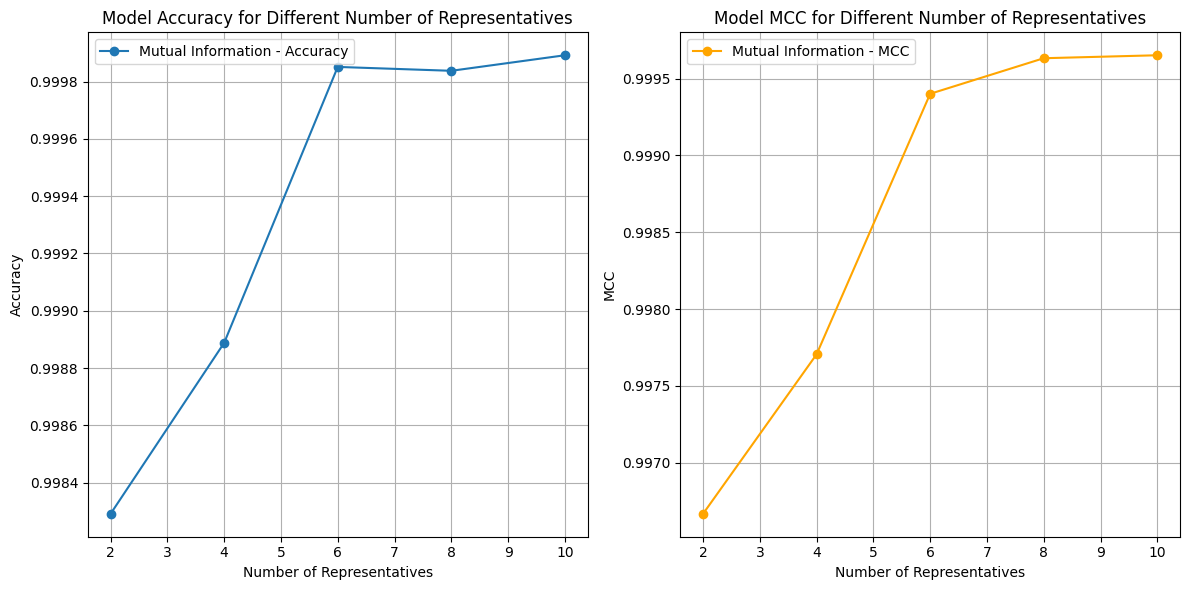

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import norm
import matplotlib.pyplot as plt
# Factor Analysis to extract latent variables
fa = FactorAnalysis(n_components=10, random_state=42)
X_train_fa = fa.fit_transform(x_train)
X_test_fa = fa.transform(x_test)
# Calculate feature importances using Mutual Information
def calculate_mutual_info_importances(X, y):
    return mutual_info_classif(X, y)

# Calculate feature importances using Mutual Information
mutual_info_indices = calculate_mutual_info_importances(X_train_fa, y_train)

# Function to build and train the Random Forest model
def build_and_train_rf(X_train, y_train, X_val, y_val):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return model, accuracy

# Evaluate the model for different number of top features
num_representatives = [2, 4, 6, 8, 10]
accuracies_mutual_info = []
mcc_scores = []

for k in num_representatives:
    top_k_indices = np.argsort(mutual_info_indices)[-k:]
    X_train_top_k = X_train_fa[:, top_k_indices]
    X_test_top_k = X_test_fa[:, top_k_indices]

    # Split train data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_top_k, y_train, test_size=0.2, random_state=42)

    model, accuracy = build_and_train_rf(X_train_split, y_train_split, X_val_split, y_val_split)
    accuracies_mutual_info.append(accuracy)

    # Calculate MCC score for the test set
    y_pred_test = model.predict(X_test_top_k)
    mcc = matthews_corrcoef(y_test, y_pred_test)
    mcc_scores.append(mcc)

    print(f"Model accuracy with top {k} representatives (Mutual Information): {accuracy}")
    print(f"Model MCC with top {k} representatives (Mutual Information): {mcc}")

# Plot the accuracies and MCC scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_representatives, accuracies_mutual_info, marker='o', label='Mutual Information - Accuracy')
plt.xlabel('Number of Representatives')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Number of Representatives')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_representatives, mcc_scores, marker='o', label='Mutual Information - MCC', color='orange')
plt.xlabel('Number of Representatives')
plt.ylabel('MCC')
plt.title('Model MCC for Different Number of Representatives')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TRUST XAI: Generating explanations using Gaussian distribution for contributions
# def gaussian_contributions(num_representatives):
#     # Generate Gaussian-distributed contributions
#     mu, sigma = 0, 0.1  # mean and standard deviation
#     contributions = norm(mu, sigma).rvs(num_representatives)
#     contributions = np.abs(contributions)  # Make all contributions positive
#     contributions /= contributions.sum()  # Normalize to sum to 1
#     return contributions

# # Explanation for a single test instance
# k = 6  # You can adjust this value
# top_k_indices = np.argsort(mutual_info_indices)[-k:]
# X_train_top_k = X_train_fa[:, top_k_indices]
# X_test_top_k = X_test_fa[:, top_k_indices]

# # Re-train the RF model with top k representatives
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train_top_k, y_train)

# # Select a single test instance
# test_instance = X_test_top_k[0].reshape(1, -1)
# predicted_label = rf_model.predict(test_instance)
# predicted_probabilities = rf_model.predict_proba(test_instance)

# # Calculate contribution of each representative using Gaussian distribution
# contributions = gaussian_contributions(k)

# # Output explanation
# print("Explanation for the test instance:")
# print(f"Predicted label: {predicted_label[0]}")
# print(f"Predicted probabilities: {predicted_probabilities[0]}")
# print("Contributions of each representative:")
# for idx, contribution in zip(top_k_indices, contributions):
#     print(f"Representative {idx}: Contribution = {contribution:.4f}")

# # Show the representatives chosen and their feature contributions
# representatives = fa.components_[top_k_indices]

# top_contributing_features = {}

# for idx, representative in zip(top_k_indices, representatives):
#     top_features = np.argsort(-np.abs(representative))[:5]  # Get top 5 contributing features
#     top_contributing_features[idx] = [(x.columns[feature_idx], representative[feature_idx]) for feature_idx in top_features]
#     print(f"\nRepresentative {idx}:")
#     for feature, contribution in top_contributing_features[idx]:
#         print(f"Feature: {feature}, Contribution: {contribution:.4f}")

# # Output the top contributing features for each representative
# for rep_idx, features in top_contributing_features.items():
#     print(f"\nTop contributing features for representative {rep_idx}:")
#     for feature, contribution in features:
#         print(f"Feature: {feature}, Contribution: {contribution:.4f}")

In [ ]:
def gaussian_contributions(num_representatives):
    # Generate Gaussian-distributed contributions
    mu, sigma = 0, 0.1  # mean and standard deviation
    contributions = norm(mu, sigma).rvs(num_representatives)
    contributions = np.abs(contributions)  # Make all contributions positive
    contributions /= contributions.sum()  # Normalize to sum to 1
    return contributions

# Explanation for a single test instance
k = 6  # You can adjust this value
top_k_indices = np.argsort(mutual_info_indices)[-k:]
X_train_top_k = X_train_fa[:, top_k_indices]
X_test_top_k = X_test_fa[:, top_k_indices]

# Re-train the RF model with top k representatives
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_top_k, y_train)

# Select a single test instance
test_instance = X_test_top_k[0].reshape(1, -1)
predicted_label = rf_model.predict(test_instance)
predicted_probabilities = rf_model.predict_proba(test_instance)

# Calculate contribution of each representative using Gaussian distribution
contributions = gaussian_contributions(k)

# Output explanation
print("Explanation for the test instance:")
print(f"Predicted label: {predicted_label[0]}")
print(f"Predicted probabilities: {predicted_probabilities[0]}")
print("Contributions of each representative:")
for idx, contribution in zip(top_k_indices, contributions):
    print(f"Representative {idx}: Contribution = {contribution:.4f}")

# Show the representatives chosen and their feature contributions
representatives = fa.components_[top_k_indices]

top_contributing_features = {}

# Assuming feature_names is a list of column names
feature_names = data.columns  # Replace this with the actual feature names if different

for idx, representative in zip(top_k_indices, representatives):
    top_features = np.argsort(-np.abs(representative))[:5]  # Get top 5 contributing features
    top_contributing_features[idx] = [(feature_names[feature_idx], representative[feature_idx]) for feature_idx in top_features]
    print(f"\nRepresentative {idx}:")
    for feature, contribution in top_contributing_features[idx]:
        print(f"Feature: {feature}, Contribution: {contribution:.4f}")

# Output the top contributing features for each representative
for rep_idx, features in top_contributing_features.items():
    print(f"\nTop contributing features for representative {rep_idx}:")
    for feature, contribution in features:
        print(f"Feature: {feature}, Contribution: {contribution:.4f}")

Explanation for the test instance:
Predicted label: 8
Predicted probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Contributions of each representative:
Representative 4: Contribution = 0.0019
Representative 5: Contribution = 0.2252
Representative 3: Contribution = 0.1750
Representative 0: Contribution = 0.2418
Representative 1: Contribution = 0.2050
Representative 2: Contribution = 0.1511

Representative 4:
Feature: src_ip_bytes, Contribution: 168824.7899
Feature: dst_ip_bytes, Contribution: 82024.1321
Feature: dst_bytes, Contribution: 1278.8026
Feature: src_pkts, Contribution: 388.4377
Feature: dst_pkts, Contribution: 368.9110

Representative 5:
Feature: dst_ip_bytes, Contribution: 156725.9477
Feature: src_ip_bytes, Contribution: -70432.7491
Feature: dst_bytes, Contribution: -1595.8068
Feature: dst_pkts, Contribution: 219.7703
Feature: src_port, Contribution: 152.3517

Representative 3:
Feature: dst_bytes, Contribution: 9016485.6913
Feature: src_ip_bytes, Contribution: -4015.7361
Feature

In [ ]:
x_wo = data.drop(['label'], axis=1).values
y_wo = data['label'].values
# scaling the dataset.
ro_scaler = RobustScaler()
x_wo_scaled = ro_scaler.fit_transform(x_wo)

scaler = MinMaxScaler()
x_wo_scaled = scaler.fit_transform(x_wo_scaled)
x_wo_train , x_wo_test , y_wo_train , y_wo_test = train_test_split(x_wo_scaled, y_wo, test_size= 0.2 , random_state=42)
xl_wo_test = data_test.drop(['label'], axis=1).values
yl_wo_test = data_test['label'].values
scaler = MinMaxScaler()
xl_wo_test = scaler.fit_transform(xl_wo_test)

x_traincpy = np.copy(x_wo_train)
y_traincpy = np.copy(y_wo_train)
x_testcpy = np.copy(x_wo_test)
y_testcpy = np.copy(y_wo_test)

random = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
random_cross = fit_and_evaluate(random, x_traincpy , x_testcpy , y_traincpy , y_testcpy)

print('Random Forest Performance on the test set: Cross Validation Score = %0.4f' % random_cross)
xl_testcpy = np.copy(xl_wo_test)
yl_testcpy = np.copy(yl_wo_test)

y_pred = random.predict(xl_testcpy)
print("Accuracy: ", accuracy_score(yl_testcpy, y_pred))


# Explain the model using LIME and SHAP
explainer_lime = explain_model(random, x_traincpy, 'lime')
explainer_shap = explain_model(random, x_traincpy, 'shap')

# Lime explanation
lime_explanation = explainer_lime.explain_instance(xl_testcpy[0], random.predict_proba, num_features=len(data.drop(['label'], axis=1).columns))
lime_explanation.show_in_notebook(show_table=True)

Random Forest Performance on the test set: Cross Validation Score = 1.0000
Accuracy:  0.9999975478416102


In [ ]:
explainer_shap = shap.TreeExplainer(random)
shap_values = explainer_shap.shap_values(x_testcpy)

<Figure size 640x480 with 0 Axes>

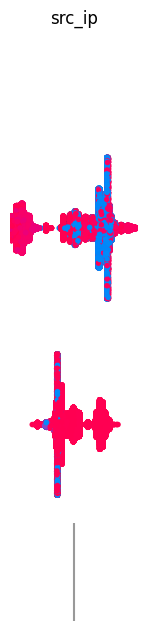

In [ ]:
explainer_shap = explain_model(random, x_traincpy, 'shap')
shap.summary_plot(shap_values, x_testcpy, feature_names=data.columns[:-1] , show=False)

# Save the plot as a file
plt.savefig('shap_rf_plot.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

# Display the plot
img = plt.imread('shap_rf_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load NSL-KDD dataset
df = pd.read_csv('Train_Test_Network.csv', header=None)
df.columns =  ['ts',
 'src_ip',
 'src_port',
 'dst_ip',
 'dst_port',
 'proto',
 'service',
 'duration',
 'src_bytes',
 'dst_bytes',
 'conn_state',
 'missed_bytes',
 'src_pkts',
 'src_ip_bytes',
 'dst_pkts',
 'dst_ip_bytes',
 'dns_query',
 'dns_qclass',
 'dns_qtype',
 'dns_rcode',
 'dns_AA',
 'dns_RD',
 'dns_RA',
 'dns_rejected',
 'ssl_version',
 'ssl_cipher',
 'ssl_resumed',
 'ssl_established',
 'ssl_subject',
 'ssl_issuer',
 'http_trans_depth',
 'http_method',
 'http_uri',
 'http_version',
 'http_request_body_len',
 'http_response_body_len',
 'http_status_code',
 'http_user_agent',
 'http_orig_mime_types',
 'http_resp_mime_types',
 'weird_name',
 'weird_addl',
 'weird_notice',
 'label',
 'type']

# Map the labels to five categories: normal, dos, r2l, u2r, probe
# attack_types = {
#     'normal': 'normal',
#     'back': 'dos', 'land': 'dos', 'neptune': 'dos', 'pod': 'dos', 'smurf': 'dos', 'teardrop': 'dos', 'apache2': 'dos', 'udpstorm': 'dos', 'processtable': 'dos', 'worm': 'dos',
#     'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'multihop': 'r2l', 'phf': 'r2l', 'spy': 'r2l', 'warezclient': 'r2l', 'warezmaster': 'r2l', 'sendmail': 'r2l', 'named': 'r2l', 'snmpgetattack': 'r2l', 'snmpguess': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l',
#     'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r', 'httptunnel': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'xterm': 'u2r',
#     'ipsweep': 'probe', 'mscan': 'probe', 'nmap': 'probe', 'portsweep': 'probe', 'saint': 'probe', 'satan': 'probe'
# }
# df['label'] = df['label'].map(attack_types)
df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'dos',inplace=True)
df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'r2l',inplace=True)
df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'probe',inplace=True)
df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'u2r',inplace=True)

# Encode the labels as integers
label_mapping = {'normal': 0, 'dos': 1, 'r2l': 2, 'u2r': 3, 'probe': 4}
df['label'] = df['label'].map(label_mapping)

# Splitting features and labels
X = df.drop(['label'], axis=1)
y = df['label']

# Check data types and handle categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
if not categorical_cols.empty:
    X = pd.get_dummies(X, columns=categorical_cols)

# Check for NaN values in the features
if X.isna().any().any():
    print("NaN values found in the features. Filling NaN values with 0.")
    X = X.fillna(0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle missing values
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Factor Analysis to extract latent variables
fa = FactorAnalysis(n_components=10, random_state=42)
X_train_fa = fa.fit_transform(X_train)
X_test_fa = fa.transform(X_test)

In [ ]:
# Calculate feature importances using Mutual Information
def calculate_mutual_info_importances(X, y):
    return mutual_info_classif(X, y)

# Calculate feature importances using Mutual Information
mutual_info_indices = calculate_mutual_info_importances(X_train_fa, y_train)

# Function to build and train the Random Forest model
def build_and_train_rf(X_train, y_train, X_val, y_val):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return model, accuracy

# Evaluate the model for different number of top features
num_representatives = [2, 4, 6, 8, 10]
accuracies_mutual_info = []
mcc_scores = []

for k in num_representatives:
    top_k_indices = np.argsort(mutual_info_indices)[-k:]
    X_train_top_k = X_train_fa[:, top_k_indices]
    X_test_top_k = X_test_fa[:, top_k_indices]

    # Split train data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_top_k, y_train, test_size=0.2, random_state=42)

    model, accuracy = build_and_train_rf(X_train_split, y_train_split, X_val_split, y_val_split)
    accuracies_mutual_info.append(accuracy)

    # Calculate MCC score for the test set
    y_pred_test = model.predict(X_test_top_k)
    mcc = matthews_corrcoef(y_test, y_pred_test)
    mcc_scores.append(mcc)

    print(f"Model accuracy with top {k} representatives (Mutual Information): {accuracy}")
    print(f"Model MCC with top {k} representatives (Mutual Information): {mcc}")

# Plot the accuracies and MCC scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_representatives, accuracies_mutual_info, marker='o', label='Mutual Information - Accuracy')
plt.xlabel('Number of Representatives')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Number of Representatives')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_representatives, mcc_scores, marker='o', label='Mutual Information - MCC', color='orange')
plt.xlabel('Number of Representatives')
plt.ylabel('MCC')
plt.title('Model MCC for Different Number of Representatives')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TRUST XAI: Generating explanations using Gaussian distribution for contributions
def gaussian_contributions(num_representatives):
    # Generate Gaussian-distributed contributions
    mu, sigma = 0, 0.1  # mean and standard deviation
    contributions = norm(mu, sigma).rvs(num_representatives)
    contributions = np.abs(contributions)  # Make all contributions positive
    contributions /= contributions.sum()  # Normalize to sum to 1
    return contributions

# Explanation for a single test instance
k = 6  # You can adjust this value
top_k_indices = np.argsort(mutual_info_indices)[-k:]
X_train_top_k = X_train_fa[:, top_k_indices]
X_test_top_k = X_test_fa[:, top_k_indices]

# Re-train the RF model with top k representatives
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_top_k, y_train)

# Select a single test instance
test_instance = X_test_top_k[0].reshape(1, -1)
predicted_label = rf_model.predict(test_instance)
predicted_probabilities = rf_model.predict_proba(test_instance)

# Calculate contribution of each representative using Gaussian distribution
contributions = gaussian_contributions(k)

# Output explanation
print("Explanation for the test instance:")
print(f"Predicted label: {predicted_label[0]}")
print(f"Predicted probabilities: {predicted_probabilities[0]}")
print("Contributions of each representative:")
for idx, contribution in zip(top_k_indices, contributions):
    print(f"Representative {idx}: Contribution = {contribution:.4f}")

# Show the representatives chosen and their feature contributions
representatives = fa.components_[top_k_indices]

top_contributing_features = {}

for idx, representative in zip(top_k_indices, representatives):
    top_features = np.argsort(-np.abs(representative))[:5]  # Get top 5 contributing features
    top_contributing_features[idx] = [(X.columns[feature_idx], representative[feature_idx]) for feature_idx in top_features]
    print(f"\nRepresentative {idx}:")
    for feature, contribution in top_contributing_features[idx]:
        print(f"Feature: {feature}, Contribution: {contribution:.4f}")

# Output the top contributing features for each representative
for rep_idx, features in top_contributing_features.items():
    print(f"\nTop contributing features for representative {rep_idx}:")
    for feature, contribution in features:
        print(f"Feature: {feature}, Contribution: {contribution:.4f}")

In [ ]:
data = pd.read_csv('Train_Test_Network.csv')

from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert labels to integers for StratifiedKFold
y_labels = data['label'].values
X = data.drop(columns=['label']).values

# Standardize the dataset once for all splits
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare arrays to store results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Cross-validation loop
for train_index, val_index in skf.split(X_scaled, y_labels):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_labels[train_index], y_labels[val_index]

    # Convert labels to categorical for Keras
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=5)

    # Build the model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # 64 neurons, first hidden layer
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(5, activation='softmax'))  # output layer

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Use early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train_cat, epochs=5, batch_size=32, validation_data=(X_val, y_val_cat), callbacks=[early_stopping], verbose=0)

    # Predict on validation data
    y_pred_prob = model.predict(X_val)
    y_pred = y_pred_prob.argmax(axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    # Store results
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Report cross-validation results
print(f"Cross-Validation Results ({n_splits}-fold):")
print(f"Average Accuracy: {np.mean(accuracy_scores) * 100:.2f}% ± {np.std(accuracy_scores) * 100:.2f}%")
print(f"Average Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")


ValueError: could not convert string to float: '3.122.49.24'